In [17]:
#setup & import
# Imports

import pandas as pd
import pickle
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import joblib

In [27]:
# Define our cohort name (matching the folder in 'data/')
cohort = "mimic_cohort_NF_30_days"

In [32]:
#Loading cohort file

try:
    target = pd.read_csv(f"../data/{cohort}/{cohort}.csv.gz", compression="gzip", index_col=0) #main cohort data
    icd_codes_data2 = pd.read_csv(f"../data/{cohort}/{cohort}_icd_codes_upto.csv.gz", compression="gzip", index_col=0)
    print("File loaded successfully.")
except FileNotFoundError:
    print("\n FileNotFoundError: The file was not found at that path. please double check")
except Exception as e:
    print(e)

#ICD preprocessing (grouping first 3 chars + merge age/gender)
icd_codes_data2["icd_code_group"] = icd_codes_data2["icd_code"].str[:3]  #selecting first 3 characters of ICD code
icd_codes_data2 = icd_codes_data2.merge(
    target[["hadm_id", "age", "gender"]],
    on=["subject_id", "hadm_id"],
    how="left")
display(icd_codes_data2)

File loaded successfully.


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_code_group,age,gender
0,10010231,23835132,1,K2960,10,Other gastritis without bleeding,K29,57.0,M
1,10010231,23835132,2,D61810,10,Antineoplastic chemotherapy induced pancytopenia,D61,57.0,M
2,10010231,23835132,3,C92Z0,10,Other myeloid leukemia not having achieved rem...,C92,57.0,M
3,10010231,23835132,4,K219,10,Gastro-esophageal reflux disease without esoph...,K21,57.0,M
4,10010231,23835132,5,E860,10,Dehydration,E86,57.0,M
...,...,...,...,...,...,...,...,...,...
406259,19999784,25127296,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406260,19999784,25989171,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406261,19999784,27302283,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406262,19999784,27773137,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M


In [40]:
# CREATE BINARY PATIENT-FEATURE MATRIX

X_full = (icd_codes_data2.groupby(["hadm_id", "icd_code"]).size().unstack("icd_code").fillna(0).astype(int))
X_full = (X_full > 0).astype(int)
print(f"X_full shape: {X_full.shape}")
print(f"Total hadm_ids in X_full: {len(X_full)}")
X_full

X_full shape: (4539, 6952)
Total hadm_ids in X_full: 4539


icd_code,00581,0071,00845,00869,0088,0090,0091,0092,0093,01600,...,Z9862,Z98818,Z9882,Z9884,Z9885,Z9889,Z98890,Z992,Z993,Z9981
hadm_id,,,,,,,,,,,,,,,,,,,,,
20000588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20004072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20004811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20006731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20008395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29987780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29990599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# 4. ALIGN TARGET

target_indexed = target.set_index("hadm_id")
valid_ids = X_full.index.intersection(target_indexed.index)
X_full = X_full.loc[valid_ids]
y_full = target_indexed.loc[valid_ids]["label"]

print(f"Valid (matching) hadm_ids: {len(valid_ids)}")
print("Label distribution:")
print(y_full.value_counts())

Valid (matching) hadm_ids: 4451
Label distribution:
label
0    4224
1     227
Name: count, dtype: int64


In [46]:
# 5. CREATE 5 FOLDS USING VALID IDS ONLY

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_ids = list(kf.split(valid_ids))

In [47]:
# Train & evaluate XGBoost per fold

fold_metrics = []
all_y_test = []
all_y_pred = []
all_y_pred_proba = []

for fold_num, (train_idx, test_idx) in enumerate(fold_ids):

    train_ids = valid_ids[train_idx]
    test_ids = valid_ids[test_idx]

    X_train = X_full.loc[train_ids]
    X_test = X_full.loc[test_ids]

    y_train = y_full.loc[train_ids]
    y_test = y_full.loc[test_ids]
    
    # Handling Imbalance
    # Calculate the ratio for scale_pos_weight
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    model = XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42,
            eval_metric="logloss", n_jobs=-1,scale_pos_weight=scale_pos_weight
            )
    #Train
    model.fit(X_train, y_train)

    #Evaluate
    print("Evaluating Model...\n")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Store predictions for aggregate evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_proba.extend(y_pred_proba)
    
    # Metrics per fold 
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    fold_metrics.append({'fold': fold_num, 'AUC': auc, 'Accuracy': acc, 'F1': f1, 'Precision': prec, 'Recall': rec})
    print(f"Fold {fold_num} -> AUC: {auc:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

Evaluating Model...

Fold 0 -> AUC: 0.7856, Acc: 0.9125, F1: 0.2909, Prec: 0.2667, Recall: 0.3200
Evaluating Model...

Fold 1 -> AUC: 0.7511, Acc: 0.9202, F1: 0.2366, Prec: 0.2200, Recall: 0.2558
Evaluating Model...

Fold 2 -> AUC: 0.7783, Acc: 0.9112, F1: 0.2476, Prec: 0.2364, Recall: 0.2600
Evaluating Model...

Fold 3 -> AUC: 0.7180, Acc: 0.9056, F1: 0.2632, Prec: 0.2174, Recall: 0.3333
Evaluating Model...

Fold 4 -> AUC: 0.7715, Acc: 0.9180, F1: 0.2316, Prec: 0.1964, Recall: 0.2821



Aggregate -> AUC: 0.7605, Acc: 0.9135, F1: 0.2553, Prec: 0.2276, Recall: 0.2907


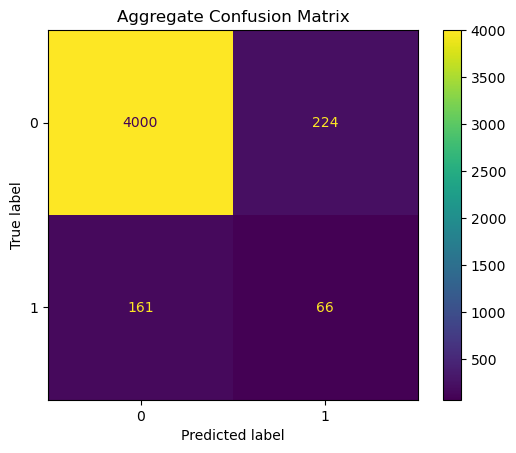

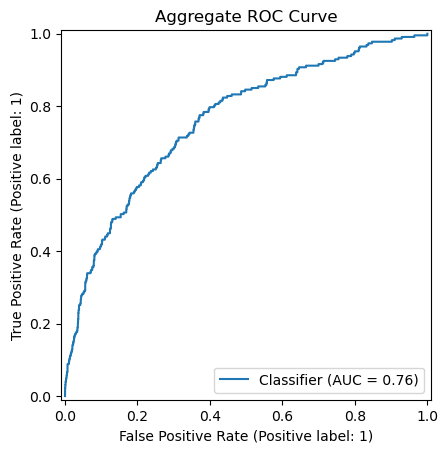

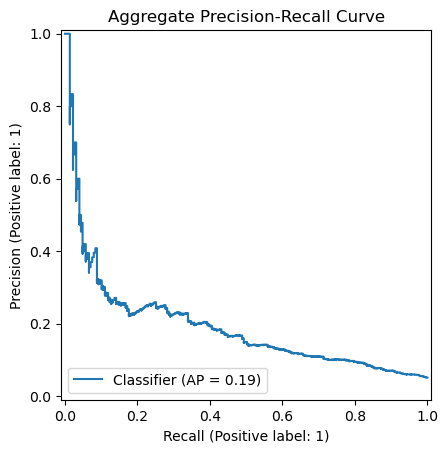

In [48]:
# ---------- Aggregate Metrics ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_y_pred_proba = np.array(all_y_pred_proba)

agg_auc = roc_auc_score(all_y_test, all_y_pred_proba)
agg_acc = accuracy_score(all_y_test, all_y_pred)
agg_f1 = f1_score(all_y_test, all_y_pred)
agg_prec = precision_score(all_y_test, all_y_pred)
agg_rec = recall_score(all_y_test, all_y_pred)

print(f"\nAggregate -> AUC: {agg_auc:.4f}, Acc: {agg_acc:.4f}, F1: {agg_f1:.4f}, Prec: {agg_prec:.4f}, Recall: {agg_rec:.4f}")

# ---------- Aggregate Plots ----------
cm = confusion_matrix(all_y_test, all_y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Aggregate Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(all_y_test, all_y_pred_proba)
plt.title("Aggregate ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(all_y_test, all_y_pred_proba)
plt.title("Aggregate Precision-Recall Curve")
plt.show()

In [51]:
# Cross-validation summary (mean ± std)

auc_list = [m['AUC'] for m in fold_metrics]
acc_list = [m['Accuracy'] for m in fold_metrics]
f1_list = [m['F1'] for m in fold_metrics]
prec_list = [m['Precision'] for m in fold_metrics]
rec_list = [m['Recall'] for m in fold_metrics]

print("\n=== CV Summary ===")
print(f"Mean AUC: {np.mean(auc_list):.4f} ± {np.std(auc_list):.4f}")
print(f"Mean Accuracy: {np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}")
print(f"Mean F1: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
print(f"Mean Precision: {np.mean(prec_list):.4f} ± {np.std(prec_list):.4f}")
print(f"Mean Recall: {np.mean(rec_list):.4f} ± {np.std(rec_list):.4f}")

# ---------- Summary Table ----------
display(pd.DataFrame(fold_metrics))



=== CV Summary ===
Mean AUC: 0.7609 ± 0.0244
Mean Accuracy: 0.9135 ± 0.0052
Mean F1: 0.2540 ± 0.0214
Mean Precision: 0.2274 ± 0.0234
Mean Recall: 0.2902 ± 0.0313


,fold,AUC,Accuracy,F1,Precision,Recall
0,0,0.785636,0.912458,0.290909,0.266667,0.320000
1,1,0.751050,0.920225,0.236559,0.220000,0.255814
2,2,0.778333,0.911236,0.247619,0.236364,0.260000
3,3,0.718001,0.905618,0.263158,0.217391,0.333333
4,4,0.771521,0.917978,0.231579,0.196429,0.282051


In [53]:
# Training final model on full dataset

# Align labels with X_full indices (valid hadm_ids only)
y_full = target.set_index('hadm_id').loc[valid_ids]['label']

final_model = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss"
)
final_model.fit(X_full, y_full)

# Save the model
joblib.dump(final_model, f"../models/{cohort}__icd_codes_upto_xgb_model.pkl")
print(f"Final model trained on full dataset and saved at ../models/{cohort}_icd_codes_upto_xgb_model.pkl")

Final model trained on full dataset and saved at ../models/mimic_cohort_NF_30_days_icd_codes_upto_xgb_model.pkl
